In [115]:
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import random
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import segmentation_models_pytorch as smp
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score
from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_curve

In [ ]:
# Define image preprocessing (resize, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Dataset class
class BreastCancerDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(root_dir, "*/*/*.png"), recursive=True)
        self.transform = transform
        print(f"Found {len(self.image_paths)} images in {root_dir}")  # Debugging statement

        # Debugging: Count the number of images in each class
        self.num_class_0 = sum(1 for path in self.image_paths if os.path.normpath(path).split(os.sep)[-2] == '0')
        self.num_class_1 = sum(1 for path in self.image_paths if os.path.normpath(path).split(os.sep)[-2] == '1')
        print(f"Number of class 0 images: {self.num_class_0}")
        print(f"Number of class 1 images: {self.num_class_1}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = 1 if os.path.normpath(img_path).split(os.sep)[-2] == '1' else 0  # Detect class
        if self.transform:
            image = self.transform(image)
        return image, label

# Determine dataset path
dataset_path = "breast-histopathology-images/versions/1/IDC_regular_ps50_idx5"
print(f"Dataset path resolved to: {dataset_path}")  # Debugging statement

full_dataset = BreastCancerDataset(dataset_path, transform=transform)

if len(full_dataset) == 0:
    print("No images found!")

# Split dataset
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


# Balance the test set to have an equal number of 0 and 1 labels
test_indices_0 = [i for i, (image, label) in enumerate(test_dataset) if label == 0]
test_indices_1 = [i for i, (image, label) in enumerate(test_dataset) if label == 1]

# Ensure equal number of samples from both classes
min_test_samples = min(len(test_indices_0), len(test_indices_1))
balanced_test_indices = test_indices_0[:min_test_samples] + test_indices_1[:min_test_samples]
test_dataset = Subset(test_dataset, balanced_test_indices)

print(f"Dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")  # Debugging statement

# Enable subset mode for quick testing
use_subset = False  # Change to False for full dataset
if use_subset:
    subset_size = 3000  # Reduce dataset size for testing
    val_subset_size = int(subset_size * 0.1)
    test_subset_size = int(subset_size * 0.1)

    if len(train_dataset) > 0:
        train_indices = np.random.choice(len(train_dataset), subset_size, replace=False)
        train_dataset = Subset(train_dataset, train_indices)
    else:
        print("Warning: train_dataset is empty!")

    if len(val_dataset) > 0:
        val_indices = np.random.choice(len(val_dataset), val_subset_size, replace=False)
        val_dataset = Subset(val_dataset, val_indices)
    else:
        print("Warning: val_dataset is empty!")

    if len(test_dataset) > 0:
        test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)
        test_dataset = Subset(test_dataset, test_indices)
    else:
        print("Warning: test_dataset is empty!")

# Create DataLoaders
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Final dataset sizes - Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")  # Debugging statement

Dataset path resolved to: breast-histopathology-images/versions/1/IDC_regular_ps50_idx5
Found 277524 images in breast-histopathology-images/versions/1/IDC_regular_ps50_idx5
Number of class 0 images: 198738
Number of class 1 images: 78786
Dataset sizes - Train: 222019, Val: 27752, Test: 15838
Final dataset sizes - Train: 222019, Val: 27752, Test: 15838


In [223]:
# Model Definitions
class ConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(ConvVAE, self).__init__()

        # Encoder (Convolutional Feature Extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.fc_z = nn.Linear(latent_dim, 256*4*4)

        # Decoder (Transposed Conv for Image Reconstruction)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()  # Output in range [-1,1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc_z(z).view(-1, 256, 4, 4)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FullyConnectedVAE(nn.Module):
    def __init__(self, input_dim=64*64, latent_dim=128, dropout_rate=0.3):
        super(FullyConnectedVAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.drop1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.drop2 = nn.Dropout(dropout_rate)

        self.fc_mu = nn.Linear(512, latent_dim)   # Mean of latent space
        self.fc_logvar = nn.Linear(512, latent_dim)  # Log variance of latent space

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.drop3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.drop4 = nn.Dropout(dropout_rate)

        self.fc5 = nn.Linear(1024, input_dim)  # Output flattened image

    def encode(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = F.leaky_relu(self.bn1(self.fc1(x)), negative_slope=0.02)
        x = self.drop1(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)), negative_slope=0.02)
        x = self.drop2(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Reparameterization trick

    def decode(self, z):
        z = F.leaky_relu(self.bn3(self.fc3(z)), negative_slope=0.02)
        z = self.drop3(z)
        z = F.leaky_relu(self.bn4(self.fc4(z)), negative_slope=0.02)
        z = self.drop4(z)
        z = torch.sigmoid(self.fc5(z))  # Output in [0,1] range
        return z.view(z.size(0), 3, 64, 64)  # Reshape back to image format

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Loss function
def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x.view(x.size(0), -1), reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + 0.1 * kl_div

'\nclass FullyConnectedVAE(nn.Module):\n    def __init__(self, input_dim=3*50*50, latent_dim=32):\n        super(FullyConnectedVAE, self).__init__()\n\n        # Encoder\n        self.fc1 = nn.Linear(input_dim, 512)\n        self.fc2 = nn.Linear(512, 256)\n        self.fc_mu = nn.Linear(256, latent_dim)   # Mean of latent space\n        self.fc_logvar = nn.Linear(256, latent_dim)  # Log variance of latent space\n\n        # Decoder\n        self.fc3 = nn.Linear(latent_dim, 256)\n        self.fc4 = nn.Linear(256, 512)\n        self.fc5 = nn.Linear(512, input_dim)  # Output flattened image\n\n    def encode(self, x):\n        x = x.view(x.size(0), -1)  # Flatten input from [batch, 1, 64, 64] → [batch, 4096]\n        x = F.relu(self.fc1(x))\n        x = F.relu(self.fc2(x))\n        mu = self.fc_mu(x)\n        logvar = self.fc_logvar(x)\n        return mu, logvar\n\n    def reparameterize(self, mu, logvar):\n        std = torch.exp(0.5 * logvar)\n        eps = torch.randn_like(std)\n      

In [158]:
class AttentionLayer(nn.Module):
    def __init__(self, in_channels):
        super(AttentionLayer, self).__init__()
        reduced_channels = max(in_channels // 8, 16)  # Prevent too small channels
        self.query = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.key = nn.Conv2d(in_channels, reduced_channels, kernel_size=1)
        self.value = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        B, C, H, W = x.shape

        query = self.query(x).view(B, -1, H * W).permute(0, 2, 1)  # (B, H*W, reduced_channels)
        key = self.key(x).view(B, -1, H * W)  # (B, reduced_channels, H*W)

        attn = torch.bmm(query, key) / (query.shape[-1] ** 0.5)  # Scaled dot-product
        attn = F.softmax(attn, dim=-1)  # (B, H*W, H*W)

        value = self.value(x).view(B, -1, H * W)  # (B, C, H*W)
        out = torch.bmm(value, attn.permute(0, 2, 1)).view(B, C, H, W)  # Apply attention

        return self.gamma * out + x  # Residual connection

# ConvVAE with Attention
class AttConvVAE(nn.Module):
    def __init__(self, latent_dim=64):
        super(AttConvVAE, self).__init__()

        # Encoder (Convolutional Feature Extractor)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            AttentionLayer(32),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            AttentionLayer(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            AttentionLayer(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            AttentionLayer(256),
        )

        self.fc_mu = nn.Linear(256*4*4, latent_dim)
        self.fc_logvar = nn.Linear(256*4*4, latent_dim)
        self.fc_z = nn.Linear(latent_dim, 256*4*4)

        # Decoder (Transposed Conv for Image Reconstruction)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            AttentionLayer(128),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            AttentionLayer(64),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            AttentionLayer(32),

            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        x = torch.flatten(x, start_dim=1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.fc_z(z).view(-1, 256, 4, 4)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

In [199]:
target_image_size = 64

# Model Definitions
class UNetEncoder(nn.Module):
    def __init__(self, in_channels=3, latent_dim=28, freeze_encoder=True):
        super(UNetEncoder, self).__init__()
        self.unet = smp.Unet(
            encoder_name="resnet34", encoder_weights="imagenet", in_channels=in_channels, classes=latent_dim
        )
        self.encoder = self.unet.encoder
        self.fc_mu = nn.Sequential(
            nn.Linear(512 * (target_image_size // 32) * (target_image_size // 32), 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        self.fc_logvar = nn.Sequential(
            nn.Linear(512 * (target_image_size // 32) * (target_image_size // 32), 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False

    def forward(self, x):
        features = self.encoder(x)
        x = features[-1].view(x.size(0), -1)
        return self.fc_mu(x), self.fc_logvar(x)

class UNetDecoder(nn.Module):
    def __init__(self, latent_dim=28, out_channels=3):
        super(UNetDecoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 512 * (target_image_size // 32) * (target_image_size // 32))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, out_channels, 3, 2, 1, 1), nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z).view(-1, 512, target_image_size // 32, target_image_size // 32)
        return self.decoder(x)

class VAE(nn.Module):
    def __init__(self, latent_dim=28, freeze_encoder=True):
        super(VAE, self).__init__()
        self.encoder = UNetEncoder(latent_dim=latent_dim, freeze_encoder=freeze_encoder)
        self.decoder = UNetDecoder(latent_dim=latent_dim)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        return mu + torch.randn_like(std) * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

def loss_function(recon_x, x, mu, logvar, beta=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

In [256]:
# Load the saved model
model_path = "frozen_encoder.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# vae = ConvVAE(latent_dim=128).to(device)
# vae = FullyConnectedVAE(input_dim=3*64*64, latent_dim=64).to(device)
# vae = AttConvVAE(latent_dim=128).to(device)
vae = VAE(latent_dim=96, freeze_encoder=False).to(device)
vae.load_state_dict(torch.load(model_path, map_location=device))

<All keys matched successfully>

In [257]:
# Function to calculate MSE and KL Divergence
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction Loss (MSE)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss, kl_loss

# Function to calculate reconstruction error and classify anomalies
def calculate_metrics(model, data_loader, device, wasserstein_threshold):
    model.eval()
    y_true = []
    y_pred = []
    total_recon_loss = 0
    total_kl_loss = 0
    wasserstein_scores = []  # Use a list to collect scores

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            recon_images, mu, logvar = model(images)

            # Calculate reconstruction and KL loss
            recon_loss, kl_loss = loss_function(recon_images, images, mu, logvar)
            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()

            # Calculate Mean Squared Error (MSE) per sample
            mse = F.mse_loss(recon_images, images, reduction='none')
            mse = mse.view(mse.size(0), -1).mean(dim=1)

            # Compute Wasserstein Distance per sample
            batch_wasserstein_scores = []
            for i in range(images.shape[0]):  # Batch loop
                original = images[i].cpu().numpy().flatten()
                reconstructed = recon_images[i].cpu().numpy().flatten()
                wd = wasserstein_distance(original, reconstructed)
                batch_wasserstein_scores.append(wd)  # Append to list

            # Convert batch Wasserstein scores to NumPy array
            batch_wasserstein_scores = np.array(batch_wasserstein_scores)

            # Classify as anomaly if Wasserstein Distance is above threshold
            batch_predictions = (((batch_wasserstein_scores > wasserstein_threshold)).astype(int))
            y_pred.extend(batch_predictions)
            y_true.extend(labels.cpu().numpy())
            wasserstein_scores.extend(batch_wasserstein_scores)

    # Convert Wasserstein scores to NumPy array
    wasserstein_scores = np.array(wasserstein_scores)

    # Calculate MSE and KL Divergence
    mse = total_recon_loss / len(data_loader.dataset)
    kl_div = total_kl_loss / len(data_loader.dataset)

    # Calculate classification metrics
    accuracy = accuracy_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    AUC = roc_auc_score(y_true, wasserstein_scores)
    f1 = f1_score(y_true, y_pred)

    return mse, kl_div, accuracy, conf_matrix, wasserstein_scores, AUC, f1

In [258]:
# Function to calculate Wasserstein distances on the validation set
def calculate_wasserstein_scores(model, data_loader, device):
    model.eval()
    wasserstein_scores = []
    labels = []

    with torch.no_grad():
        for images, lbls in data_loader:
            images = images.to(device)
            lbls = lbls.to(device)
            
            # Forward pass
            recon_images, mu, logvar = model(images)

            # Compute Wasserstein Distance per sample
            batch_wasserstein_scores = []
            for i in range(images.shape[0]):  # Batch loop
                original = images[i].cpu().numpy().flatten()
                reconstructed = recon_images[i].cpu().numpy().flatten()
                wd = wasserstein_distance(original, reconstructed)
                batch_wasserstein_scores.append(wd)  # Append to list

            wasserstein_scores.extend(batch_wasserstein_scores)
            labels.extend(lbls.cpu().numpy())

    return np.array(wasserstein_scores), np.array(labels)

# Calculate Wasserstein scores on the validation set
val_wasserstein_scores, val_labels = calculate_wasserstein_scores(vae, val_loader, device)

In [259]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(val_labels, val_wasserstein_scores)

# Calculate Youden's J statistic
youden_j = tpr - fpr
optimal_idx = np.argmax(youden_j)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold}")

Optimal threshold: 0.05591383194890417


MSE: 639.8851169914229
KL Divergence: 20.018822386855202
AUC: 0.5012582011505207
F1 Score: 0.6532873229204504
Accuracy: 0.5178684177295113
Threshold: 0.05591383194890417
Confusion Matrix:


<Figure size 800x600 with 0 Axes>

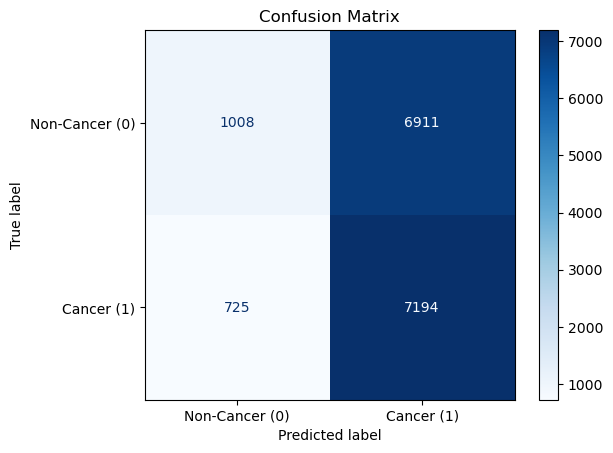

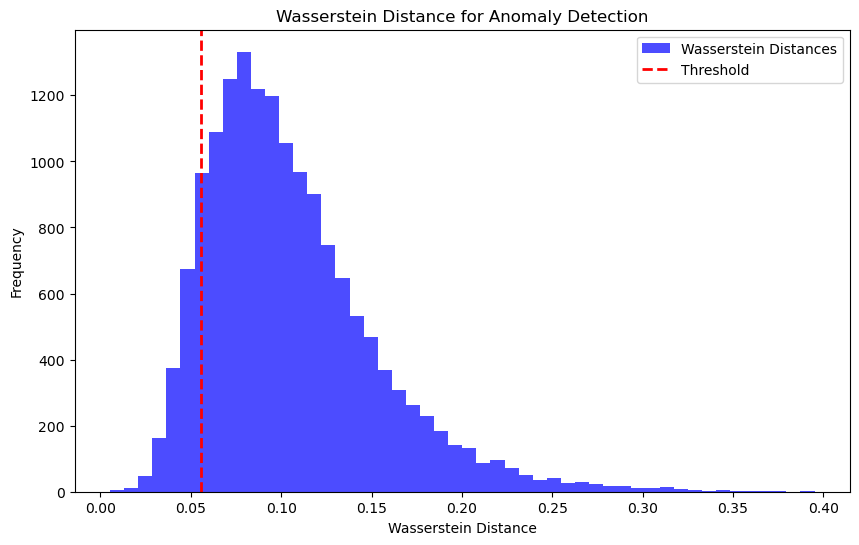

In [260]:
# Set the optimal threshold for anomaly detection
wasserstein_threshold = optimal_threshold

# Calculate metrics on the test dataset
mse, kl_div, accuracy, conf_matrix, wasserstein_scores, AUC, f1 = calculate_metrics(vae, test_loader, device, wasserstein_threshold)

# Print the metrics
print(f"MSE: {mse}")
print(f"KL Divergence: {kl_div}")
print(f"AUC: {AUC}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")
print(f"Threshold: {wasserstein_threshold}")
print("Confusion Matrix:")

# Plot the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Non-Cancer (0)", "Cancer (1)"])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))  # Increase the figure size
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Plot the Wasserstein Distance distribution
plt.figure(figsize=(10, 6))
plt.hist(wasserstein_scores, bins=50, alpha=0.7, color='b', label="Wasserstein Distances")
plt.axvline(wasserstein_threshold, color='r', linestyle='dashed', linewidth=2, label="Threshold")
plt.legend()
plt.xlabel("Wasserstein Distance")
plt.ylabel("Frequency")
plt.title("Wasserstein Distance for Anomaly Detection")
plt.show()